In [ ]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
tf.test.is_gpu_available()

In [4]:
# tf.compat.v1.enable_eager_execution()
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())


# tf.compat.v1.disable_eager_execution()
# tf.config.threading.set_inter_op_parallelism_threads(64)
# tf.config.threading.set_intra_op_parallelism_threads(64)

0
0


In [5]:
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

0
0


In [6]:
def start_profiling():
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    logdir = 'logs/func/%s' % stamp

    # Start tracing.                                                                                                                                                                              
    options = tf.profiler.experimental.ProfilerOptions(
        host_tracer_level=3, python_tracer_level=1, device_tracer_level=1, delay_ms=None
    )

    tf.profiler.experimental.start(logdir, options = options)
    return logdir
    
    
def end_profiling():
    tf.profiler.experimental.stop()

In [7]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f1(x):
    """
        https://stackoverflow.com/questions/52774351/how-to-run-parallel-map-fn-when-eager-execution-enabled
    """
    return tf.sin(tf.reduce_sum(x, axis=-1))

In [8]:
ndim = 9
sigma = 0.01
alpha = sigma * np.sqrt(2)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,9), dtype=tf.float64)])
def f2(x):
    pre = tf.cast(1.0 / (alpha * tf.sqrt(np.pi)) ** ndim, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum(x ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

In [11]:
c1 = tf.random.uniform(shape=(10,6), minval=0, maxval=10, dtype=tf.float64)
c2 = tf.random.uniform(shape=(2,9), minval=0, maxval=.04, dtype=tf.float64)

In [12]:
x = tf.compat.v1.placeholder(tf.float64, shape=[None])

with tf.compat.v1.Session() as sess:

    #writer = tf.summary.create_file_writer(logdir)

    #tf.profiler.experimental.start(logdir, options = options)                                                                                                                                
    #tf.summary.trace_on(graph=True, profiler=True)

    print(
        sess.run(
            f1(c1),
#             feed_dict={
#                 x: np.ones(4, dtype=np.int)
#             }
        )
    )

#f1(c1)

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [13]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

### F1

In [14]:
target = 128 * (np.cos(5) + np.cos(15) + np.cos(25)) * np.sin(5) **7

precision = 1e-3
target_precision = min(abs(precision * target), precision)

target, target_precision

(-49.165073816419444, 0.001)

#### Uniform

In [21]:
%%time
tf.random.set_seed(123)

ndims = 6
# max_samples = 10**9

results = []
results_means = []
results_stddevs = []
result_times = []
result_runs = []

# epoch = 0
# current_precision = 1e99

nitn_lst = list(map(int, [1e5, 1e6, 1e7]))
run_lst = list(range(1,11))

for run in run_lst:
    for nitn in nitn_lst:
        
        print(f'run={run} nitn={nitn}')

        time_a = time.time()
        samples = tf.random.uniform(shape=(nitn, ndims), minval=0, maxval=10, dtype=tf.float64)
        current_result = f1(samples) * 10 ** ndims
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)

        current_result_mean = tf.reduce_mean(current_result).numpy()
        current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result_mean)
        results_stddevs.append(current_result_stddev)
        results.append(current_result)

        # print(current_result_mean, current_result_stddev)

run=1 nitn=100000
run=1 nitn=1000000
run=1 nitn=10000000
run=2 nitn=100000
run=2 nitn=1000000
run=2 nitn=10000000
run=3 nitn=100000
run=3 nitn=1000000
run=3 nitn=10000000
run=4 nitn=100000
run=4 nitn=1000000
run=4 nitn=10000000
run=5 nitn=100000
run=5 nitn=1000000
run=5 nitn=10000000
run=6 nitn=100000
run=6 nitn=1000000
run=6 nitn=10000000
run=7 nitn=100000
run=7 nitn=1000000
run=7 nitn=10000000
run=8 nitn=100000
run=8 nitn=1000000
run=8 nitn=10000000
run=9 nitn=100000
run=9 nitn=1000000
run=9 nitn=10000000
run=10 nitn=100000
run=10 nitn=1000000
run=10 nitn=10000000
Wall time: 7.14 s


In [22]:
temp_df = pd.DataFrame({'nitn': nitn_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs':results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.nitn

In [23]:
g = temp_df.groupby('nitn')['result_means'].apply(lambda x: x.tolist())

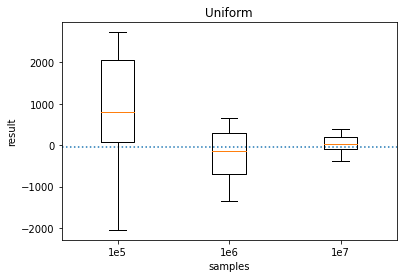

In [24]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('result')
plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

In [29]:
temp_df.groupby('nitn')['result_means'].agg([np.mean, np.std])

,mean,std
nitn,,
100000,723.782799,1556.280870
1000000,-213.129661,649.105808
10000000,24.924594,235.269052


In [31]:
24.924594 - target

74.08966781641945

In [30]:
g = temp_df.groupby('nitn')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

nitn
100000      0.043384
1000000     0.061535
10000000    0.560402
Name: result_times, dtype: float64

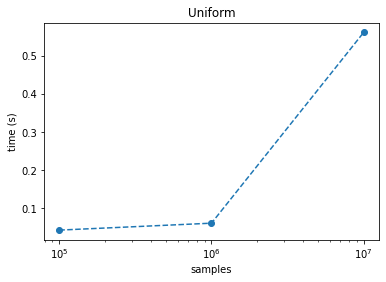

In [27]:
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

# locs, labels = plt.xticks()
# print(locs)
# plt.xticks(locs, ['', '1e5', '', '', '', '1e6', '', '', '', '1e7', '']);

# plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

In [24]:
# %%time
# tf.random.set_seed(123)

# ndims = 6
# batch_size = 1_000_000
# max_samples = 10**9

# acc = 0

# results = []
# results_means = []
# results_stddevs = []

# epoch = 0
# current_precision = 1e99

# # while current_precision > target_precision:
# for i in range(1000):
    
#     samples = tf.random.uniform(shape=(batch_size, ndims), minval=0, maxval=10, dtype=tf.float64)
# #     acc += batch_size
    
#     current_result = f1(samples) * 10 ** ndims
#     current_result_mean = tf.reduce_mean(current_result).numpy()#[0]
#     current_result_stddev = tf.math.reduce_std(current_result).numpy()#[0]
    
#     results_means.append(current_result_mean)
#     results_stddevs.append(current_result_stddev)
#     results.append(current_result)
        
# #     _, current_precision = variance_weighted_result(np.array(results_means), np.array(results_stddevs))
# #     if epoch % 10 == 0:
# #         print('Epoch: {:3d} Integral = '
# #               '{:8e} +/- {:8e} Total uncertainty = {:8e}'.format(epoch, 
# #                                                                  current_result_mean,
# #                                                                  current_result_stddev,
# #                                                                  current_precision))
    
#     epoch += 1
    
#     if epoch * batch_size >= max_samples:
#         print('BREAK')
#         break
    

In [28]:
variance_weighted_result(np.array(results_means), np.array(results_stddevs))

#### Halton

##### random

In [84]:
%%time
tf.random.set_seed(123)

ndims = 6
max_samples = 10**9

results = []
results_means = []
results_stddevs = []
result_times = []
result_runs = []

nitn_lst = list(map(int, [1e5, 1e6]))
run_lst = range(1,11)

for run in run_lst:
    for nitn in nitn_lst:
        
        print(f'run={run} nitn={nitn}')

        time_a = time.time()
        # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
        # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
        samples = tfp.mcmc.sample_halton_sequence(
            dim=ndims,
            #sequence_indices=sequence_indices,
            num_results=nitn,
            dtype=tf.float64,
            randomized=True,
            seed=run
        ) * 10
        current_result = f1(samples) * 10 ** ndims
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)

        current_result_mean = tf.reduce_mean(current_result).numpy()
        current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result_mean)
        results_stddevs.append(current_result_stddev)
        results.append(current_result)

        print(current_result_mean, current_result_stddev)

run=1 nitn=100000
-2684.727165293024 707755.160680954
run=1 nitn=1000000
-316.21792481851304 706903.625525006
run=2 nitn=100000
233.43311105750084 707005.1509722935
run=2 nitn=1000000
96.2530568268733 706856.2781893861
run=3 nitn=100000
623.7947058569523 706765.3181909428
run=3 nitn=1000000
-256.92888413327216 707438.5135474082
run=4 nitn=100000
-3228.759583475074 707428.579431426
run=4 nitn=1000000
83.76914840144384 707065.0763718383
run=5 nitn=100000
-1891.9681585841965 708202.3491739075
run=5 nitn=1000000
451.96912662761844 707022.9808683621
run=6 nitn=100000
1379.2809924961282 708240.7207025306
run=6 nitn=1000000
-462.577617774083 706683.7443619407
run=7 nitn=100000
-231.9877845655799 708168.6524728925
run=7 nitn=1000000
-216.91497404506933 707188.1130146991
run=8 nitn=100000
-1268.505048761599 707231.7068650887
run=8 nitn=1000000
-383.2498313035232 707089.0993392256
run=9 nitn=100000
-695.0241578257518 707159.3986327484
run=9 nitn=1000000
-777.9280362660645 707197.2242230295
run=1

In [85]:
# %%time
# tf.random.set_seed(123)

# ndims = 6
# max_samples = 10**9

# results = []
# results_means = []
# results_stddevs = []
# result_times = []
# result_runs = []

# epoch = 0
# current_precision = 1e99

# nitn_lst = list(map(int, [1e6]))
# run_lst = list(range(1,11))

# with tf.compat.v1.Session() as sess:

#     writer = tf.summary.create_file_writer(logdir)
#     tf.summary.trace_on(graph=True, profiler=True)

#     for run in run_lst:
#         for nitn in nitn_lst:

#             print(f'run={run} nitn={nitn}')
            
#             if run == run_lst[0] and nitn == nitn_lst[0]:
#                 print('building graph..')
#                 _ = sess.run(f1(tfp.mcmc.sample_halton_sequence(
#                     dim=ndims,
#                     #sequence_indices=sequence_indices,
#                     num_results=nitn,
#                     dtype=tf.float64,
#                     randomized=True,
#                     seed=123
#                 )) * 10 ** ndims)
#                 print('           - done')

#             time_a = time.time()
#             # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
#             # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
#             samples = tfp.mcmc.sample_halton_sequence(
#                 dim=ndims,
#                 #sequence_indices=sequence_indices,
#                 num_results=nitn,
#                 dtype=tf.float64,
#                 randomized=True,
#                 seed=run
#             )
#             # current_result = f1(samples) * 10 ** ndims
#             current_result = sess.run(f1(samples) * 10 ** ndims)
            
#             time_b = time.time() - time_a
#             result_times.append(time_b)
#             result_runs.append(run)

#             #current_result_mean = tf.reduce_mean(current_result).numpy()
#             #current_result_stddev = tf.math.reduce_std(current_result).numpy()
            
#             current_result_mean = np.mean(current_result)
#             current_result_stddev = np.std(current_result)

#             results_means.append(current_result_mean)
#             results_stddevs.append(current_result_stddev)
#             results.append(current_result)

#             print(current_result_mean, current_result_stddev)

In [86]:
temp_df = pd.DataFrame({'nitn': nitn_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs':results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.nitn

In [87]:
g = temp_df.groupby('nitn')['result_means'].apply(lambda x: x.tolist())

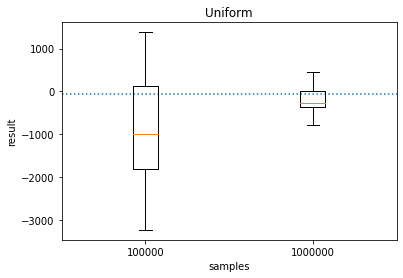

In [88]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('result')
plt.boxplot(g.values, labels=list(map(str,nitn_lst)));

In [89]:
temp_df.groupby('nitn')['result_means'].agg([np.mean, np.std])

,mean,std
nitn,,
100000,-935.600796,1471.345845
1000000,-208.670790,342.728413


In [91]:
-208.670790 - target

-159.50571618358057

In [92]:
g = temp_df.groupby('nitn')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

nitn
100000     0.402125
1000000    2.280303
Name: result_times, dtype: float64

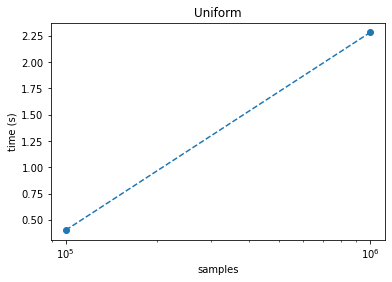

In [93]:
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

# locs, labels = plt.xticks()
# print(locs)
# plt.xticks(locs, ['', '1e5', '', '', '', '1e6', '', '', '', '1e7', '']);

# plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

##### batch

In [115]:
%%time
tf.random.set_seed(123)

ndims = 6
max_samples = 10**9

results = []
results_means = []
results_stddevs = []
result_times = []
result_runs = []

nitn_lst = list(map(int, [1e5, 1e6]))
run_lst = range(1,11)

for run in run_lst:
    for j, nitn in enumerate(nitn_lst):
        
        print(f'run={run} nitn={nitn}  b[{j*nitn}, {(j+1)*nitn}]')

        time_a = time.time()
        samples = tfp.mcmc.sample_halton_sequence(
            dim=ndims,
            sequence_indices=tf.range(start=j*nitn, limit=(j+1)*nitn, dtype=tf.int32),
            # num_results=nitn,
            dtype=tf.float64,
            randomized=True,
            seed=run
        ) * 10
        current_result = f1(samples) * 10 ** ndims
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)

        current_result_mean = tf.reduce_mean(current_result).numpy()
        current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result_mean)
        results_stddevs.append(current_result_stddev)
        results.append(current_result)

        print(current_result_mean, current_result_stddev)

run=1 nitn=100000  b[0, 100000]
-2684.727165293024 707755.160680954
run=1 nitn=1000000  b[1000000, 2000000]
211.96633015904212 707153.3759075743
run=2 nitn=100000  b[0, 100000]
233.43311105750084 707005.1509722935
run=2 nitn=1000000  b[1000000, 2000000]
27.68062540282452 707342.1371908488
run=3 nitn=100000  b[0, 100000]
623.7947058569523 706765.3181909428
run=3 nitn=1000000  b[1000000, 2000000]
363.48880889692305 707427.3631076892
run=4 nitn=100000  b[0, 100000]
-3228.759583475074 707428.579431426
run=4 nitn=1000000  b[1000000, 2000000]
817.1565466848645 707152.250548726
run=5 nitn=100000  b[0, 100000]
-1891.9681585841965 708202.3491739075
run=5 nitn=1000000  b[1000000, 2000000]
385.81905045069954 706883.333557791
run=6 nitn=100000  b[0, 100000]
1379.2809924961282 708240.7207025306
run=6 nitn=1000000  b[1000000, 2000000]
69.41305103339536 707120.3026513939
run=7 nitn=100000  b[0, 100000]
-231.9877845655799 708168.6524728925
run=7 nitn=1000000  b[1000000, 2000000]
147.74165690145423 707

In [118]:
# %%time
# tf.random.set_seed(123)

# ndims = 6
# max_samples = 10**9

# results = []
# results_means = []
# results_stddevs = []
# result_times = []
# result_runs = []

# epoch = 0
# current_precision = 1e99

# nitn_lst = list(map(int, [1e6]))
# run_lst = list(range(1,11))

# with tf.compat.v1.Session() as sess:

#     writer = tf.summary.create_file_writer(logdir)
#     tf.summary.trace_on(graph=True, profiler=True)

#     for run in run_lst:
#         for nitn in nitn_lst:

#             print(f'run={run} nitn={nitn}')
            
#             if run == run_lst[0] and nitn == nitn_lst[0]:
#                 print('building graph..')
#                 _ = sess.run(f1(tfp.mcmc.sample_halton_sequence(
#                     dim=ndims,
#                     #sequence_indices=sequence_indices,
#                     num_results=nitn,
#                     dtype=tf.float64,
#                     randomized=True,
#                     seed=123
#                 )) * 10 ** ndims)
#                 print('           - done')

#             time_a = time.time()
#             # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
#             # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
#             samples = tfp.mcmc.sample_halton_sequence(
#                 dim=ndims,
#                 #sequence_indices=sequence_indices,
#                 num_results=nitn,
#                 dtype=tf.float64,
#                 randomized=True,
#                 seed=run
#             )
#             # current_result = f1(samples) * 10 ** ndims
#             current_result = sess.run(f1(samples) * 10 ** ndims)
            
#             time_b = time.time() - time_a
#             result_times.append(time_b)
#             result_runs.append(run)

#             #current_result_mean = tf.reduce_mean(current_result).numpy()
#             #current_result_stddev = tf.math.reduce_std(current_result).numpy()
            
#             current_result_mean = np.mean(current_result)
#             current_result_stddev = np.std(current_result)

#             results_means.append(current_result_mean)
#             results_stddevs.append(current_result_stddev)
#             results.append(current_result)

#             print(current_result_mean, current_result_stddev)

In [119]:
temp_df = pd.DataFrame({'nitn': nitn_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs':results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.nitn

In [130]:
temp_df.groupby('nitn').apply(lambda x: variance_weighted_result(x['result_means'].values,
                                                                 x['results_stddevs'].values))

nitn
100000      (-935.6306416216983, 223716.6986708482)
1000000    (157.16421563140418, 223606.89811102004)
dtype: object

In [131]:
g = temp_df.groupby('nitn')['result_means'].apply(lambda x: x.tolist())

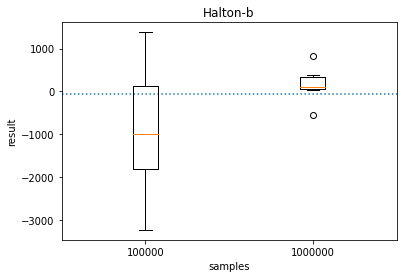

In [132]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('Halton-b')
plt.xlabel('samples')
plt.ylabel('result')
plt.boxplot(g.values, labels=list(map(str,nitn_lst)));

In [133]:
temp_df.groupby('nitn')['result_means'].agg([np.mean, np.std])

,mean,std
nitn,,
100000,-935.600796,1471.345845
1000000,157.198136,347.703160


In [134]:
157.198136 - target

206.36320981641944

In [135]:
g = temp_df.groupby('nitn')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

nitn
100000     0.215424
1000000    2.408261
Name: result_times, dtype: float64

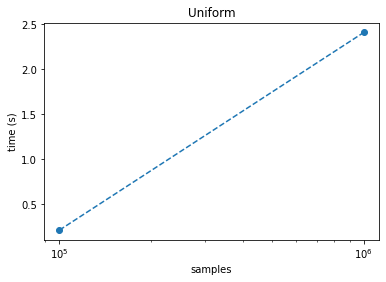

In [136]:
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

# locs, labels = plt.xticks()
# print(locs)
# plt.xticks(locs, ['', '1e5', '', '', '', '1e6', '', '', '', '1e7', '']);

# plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

#### Sobol

##### simple

In [138]:
%%time
tf.random.set_seed(123)

ndims = 6
# max_samples = 10**9

results = []
results_means = []
results_stddevs = []
result_times = []
result_runs = []

nitn_lst = list(map(int, [1e6, 1e7, 1e8]))
run_lst = range(1,11)

for nitn in nitn_lst:
    for j, run in enumerate(run_lst):
        
        print(f'run={run} nitn={nitn}')

        time_a = time.time()
        # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
        # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
        samples = tf.math.sobol_sample(
            dim=ndims,
            num_results=nitn,
            skip=j*nitn,
            dtype=tf.dtypes.float64,
            #name=None
        ) * 10
        current_result = f1(samples) * 10 ** ndims
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)

        current_result_mean = tf.reduce_mean(current_result).numpy()
        current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result_mean)
        results_stddevs.append(current_result_stddev)
        results.append(current_result)

        print(current_result_mean, current_result_stddev)

run=1 nitn=1000000
38.77633280121176 707247.9477825554
run=2 nitn=1000000
-113.73756184946373 707209.0265695094
run=3 nitn=1000000
-117.65472847696448 706944.819663731
run=4 nitn=1000000
197.8241421573584 707320.0507158055
run=5 nitn=1000000
-432.4212721420016 707202.3577269749
run=6 nitn=1000000
-119.24899966447312 707042.7511647667
run=7 nitn=1000000
-207.7835806905998 707065.9096705066
run=8 nitn=1000000
-697.4342015351656 706929.7824186041
run=9 nitn=1000000
364.06689762218616 706865.310563808
run=10 nitn=1000000
498.77143952196735 706895.162753065
run=1 nitn=10000000
-58.88415322559457 707072.4097994526
run=2 nitn=10000000
-102.84653294896049 707115.4833885349
run=3 nitn=10000000
-8.648207932638206 707143.8723734085
run=4 nitn=10000000
-61.250917433002904 707081.9124270427
run=5 nitn=10000000
-49.311014321588274 707120.095844203
run=6 nitn=10000000
37.64419487797825 707144.9078918536
run=7 nitn=10000000
-212.19794797893235 707097.520549408
run=8 nitn=10000000
50.58762695244656 707

In [140]:
# %%time
# tf.random.set_seed(123)

# ndims = 6
# max_samples = 10**9

# results = []
# results_means = []
# results_stddevs = []
# result_times = []
# result_runs = []

# epoch = 0
# current_precision = 1e99

# nitn_lst = list(map(int, [1e6]))
# run_lst = list(range(1,11))

# with tf.compat.v1.Session() as sess:

#     writer = tf.summary.create_file_writer(logdir)
#     tf.summary.trace_on(graph=True, profiler=True)

#     for run in run_lst:
#         for nitn in nitn_lst:

#             print(f'run={run} nitn={nitn}')
            
#             if run == run_lst[0] and nitn == nitn_lst[0]:
#                 print('building graph..')
#                 _ = sess.run(f1(tfp.mcmc.sample_halton_sequence(
#                     dim=ndims,
#                     #sequence_indices=sequence_indices,
#                     num_results=nitn,
#                     dtype=tf.float64,
#                     randomized=True,
#                     seed=123
#                 )) * 10 ** ndims)
#                 print('           - done')

#             time_a = time.time()
#             # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
#             # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
#             samples = tfp.mcmc.sample_halton_sequence(
#                 dim=ndims,
#                 #sequence_indices=sequence_indices,
#                 num_results=nitn,
#                 dtype=tf.float64,
#                 randomized=True,
#                 seed=run
#             )
#             # current_result = f1(samples) * 10 ** ndims
#             current_result = sess.run(f1(samples) * 10 ** ndims)
            
#             time_b = time.time() - time_a
#             result_times.append(time_b)
#             result_runs.append(run)

#             #current_result_mean = tf.reduce_mean(current_result).numpy()
#             #current_result_stddev = tf.math.reduce_std(current_result).numpy()
            
#             current_result_mean = np.mean(current_result)
#             current_result_stddev = np.std(current_result)

#             results_means.append(current_result_mean)
#             results_stddevs.append(current_result_stddev)
#             results.append(current_result)

#             print(current_result_mean, current_result_stddev)

In [141]:
temp_df = pd.DataFrame({'nitn': nitn_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs':results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.nitn

In [144]:
temp_df.groupby('nitn').apply(lambda x: variance_weighted_result(x['result_means'].values,
                                                                 x['results_stddevs'].values))

nitn
1000000        (39.59501547769465, 223612.75598088614)
10000000     (-185.99808976347754, 223605.93228349145)
100000000     (-18.04069057781748, 223593.24987476098)
dtype: object

In [145]:
g = temp_df.groupby('nitn')['result_means'].apply(lambda x: x.tolist())

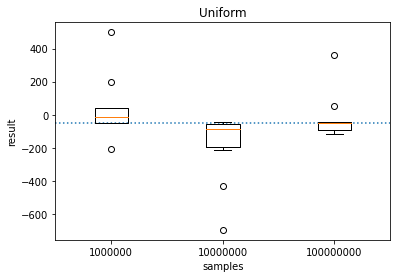

In [146]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('result')
plt.boxplot(g.values, labels=list(map(str,nitn_lst)));

In [147]:
temp_df.groupby('nitn')['result_means'].agg([np.mean, np.std])

,mean,std
nitn,,
1000000,39.579248,190.241354
10000000,-185.978715,215.896959
100000000,-18.060899,142.844200


In [150]:
-18.060899 - target

31.104174816419444

In [156]:
g = temp_df.groupby('nitn')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

nitn
1000000      3.369591
10000000     5.682208
100000000    3.619423
Name: result_times, dtype: float64

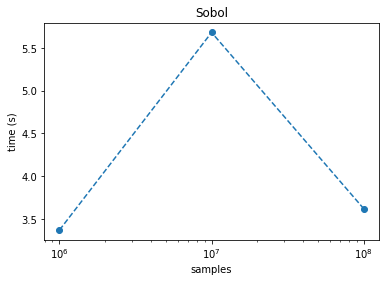

In [157]:
plt.title('Sobol')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

# locs, labels = plt.xticks()
# print(locs)
# plt.xticks(locs, ['', '1e5', '', '', '', '1e6', '', '', '', '1e7', '']);

# plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

### F2

In [158]:
target = 1

precision = 1e-3
target_precision = min(abs(precision * target), precision)

target, target_precision

(1, 0.001)

#### Uniform

In [160]:
%%time
tf.random.set_seed(123)

ndims = 9
# max_samples = 10**9

results = []
results_means = []
results_stddevs = []
result_times = []
result_runs = []

# epoch = 0
# current_precision = 1e99

nitn_lst = list(map(int, [1e5, 1e6, 1e7]))
run_lst = list(range(1,11))

for run in run_lst:
    for nitn in nitn_lst:
        
        print(f'run={run} nitn={nitn}')

        time_a = time.time()
        samples = tf.random.uniform(shape=(nitn, ndims), minval=-1, maxval=1, dtype=tf.float64)
        current_result = f2(samples) * 2 ** ndims
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)

        current_result_mean = tf.reduce_mean(current_result).numpy()
        current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result_mean)
        results_stddevs.append(current_result_stddev)
        results.append(current_result)

        # print(current_result_mean, current_result_stddev)

run=1 nitn=100000
run=1 nitn=1000000
run=1 nitn=10000000
run=2 nitn=100000
run=2 nitn=1000000
run=2 nitn=10000000
run=3 nitn=100000
run=3 nitn=1000000
run=3 nitn=10000000
run=4 nitn=100000
run=4 nitn=1000000
run=4 nitn=10000000
run=5 nitn=100000
run=5 nitn=1000000
run=5 nitn=10000000
run=6 nitn=100000
run=6 nitn=1000000
run=6 nitn=10000000
run=7 nitn=100000
run=7 nitn=1000000
run=7 nitn=10000000
run=8 nitn=100000
run=8 nitn=1000000
run=8 nitn=10000000
run=9 nitn=100000
run=9 nitn=1000000
run=9 nitn=10000000
run=10 nitn=100000
run=10 nitn=1000000
run=10 nitn=10000000
Wall time: 15.2 s


In [161]:
temp_df = pd.DataFrame({'nitn': nitn_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs':results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.nitn

In [173]:
temp_df.groupby('nitn').apply(lambda x: variance_weighted_result(x['result_means'].values,
                                                                 x['results_stddevs'].values))

E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == "__main__":


nitn
100000      (nan, 0.0)
1000000     (nan, 0.0)
10000000    (nan, 0.0)
dtype: object

In [162]:
g = temp_df.groupby('nitn')['result_means'].apply(lambda x: x.tolist())

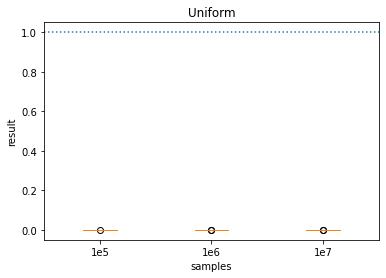

In [166]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('result')
plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

In [167]:
temp_df.groupby('nitn')['result_means'].agg([np.mean, np.std])

,mean,std
nitn,,
100000,5.060883e-192,0.000000e+00
1000000,6.036667e-229,0.000000e+00
10000000,1.854790e-116,5.865363e-116


In [168]:
0 - target

-1

In [169]:
g = temp_df.groupby('nitn')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

nitn
100000      0.187900
1000000     0.126161
10000000    1.159699
Name: result_times, dtype: float64

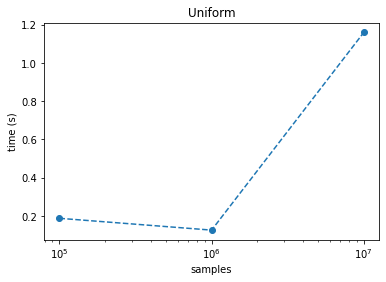

In [170]:
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

# locs, labels = plt.xticks()
# print(locs)
# plt.xticks(locs, ['', '1e5', '', '', '', '1e6', '', '', '', '1e7', '']);

# plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

In [171]:
# %%time
# tf.random.set_seed(123)

# ndims = 6
# batch_size = 1_000_000
# max_samples = 10**9

# acc = 0

# results = []
# results_means = []
# results_stddevs = []

# epoch = 0
# current_precision = 1e99

# # while current_precision > target_precision:
# for i in range(1000):
    
#     samples = tf.random.uniform(shape=(batch_size, ndims), minval=0, maxval=10, dtype=tf.float64)
# #     acc += batch_size
    
#     current_result = f1(samples) * 10 ** ndims
#     current_result_mean = tf.reduce_mean(current_result).numpy()#[0]
#     current_result_stddev = tf.math.reduce_std(current_result).numpy()#[0]
    
#     results_means.append(current_result_mean)
#     results_stddevs.append(current_result_stddev)
#     results.append(current_result)
        
# #     _, current_precision = variance_weighted_result(np.array(results_means), np.array(results_stddevs))
# #     if epoch % 10 == 0:
# #         print('Epoch: {:3d} Integral = '
# #               '{:8e} +/- {:8e} Total uncertainty = {:8e}'.format(epoch, 
# #                                                                  current_result_mean,
# #                                                                  current_result_stddev,
# #                                                                  current_precision))
    
#     epoch += 1
    
#     if epoch * batch_size >= max_samples:
#         print('BREAK')
#         break
    

#### Halton

##### random

In [175]:
%%time
tf.random.set_seed(123)

ndims = 9
# max_samples = 10**9

results = []
results_means = []
results_stddevs = []
result_times = []
result_runs = []

nitn_lst = list(map(int, [1e5, 1e6]))
run_lst = range(1,11)

for run in run_lst:
    for nitn in nitn_lst:
        
        print(f'run={run} nitn={nitn}')

        time_a = time.time()
        # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
        # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
        samples = tfp.mcmc.sample_halton_sequence(
            dim=ndims,
            #sequence_indices=sequence_indices,
            num_results=nitn,
            dtype=tf.float64,
            randomized=True,
            seed=run
        ) * 2 - 1
        current_result = f2(samples) * 2 ** ndims
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)

        current_result_mean = tf.reduce_mean(current_result).numpy()
        current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result_mean)
        results_stddevs.append(current_result_stddev)
        results.append(current_result)

        print(current_result_mean, current_result_stddev)

run=1 nitn=100000
0.0 0.0
run=1 nitn=1000000
1.0594281111040677e-268 0.0
run=2 nitn=100000
0.0 0.0
run=2 nitn=1000000
1.6426567738978444e-182 0.0
run=3 nitn=100000
0.0 0.0
run=3 nitn=1000000
5.9157551680450865e-182 0.0
run=4 nitn=100000
0.0 0.0
run=4 nitn=1000000
0.0 0.0
run=5 nitn=100000
0.0 0.0
run=5 nitn=1000000
0.0 0.0
run=6 nitn=100000
0.0 0.0
run=6 nitn=1000000
2.7168147459099836e-258 0.0
run=7 nitn=100000
0.0 0.0
run=7 nitn=1000000
1.3533298683756675e-284 0.0
run=8 nitn=100000
1.1884269089070179e-237 0.0
run=8 nitn=1000000
7.781990145327105e-78 7.781986254331106e-75
run=9 nitn=100000
0.0 0.0
run=9 nitn=1000000
0.0 0.0
run=10 nitn=100000
0.0 0.0
run=10 nitn=1000000
1.5754535981359882e-93 1.575452810408983e-90
Wall time: 38.5 s


In [176]:
# %%time
# tf.random.set_seed(123)

# ndims = 6
# max_samples = 10**9

# results = []
# results_means = []
# results_stddevs = []
# result_times = []
# result_runs = []

# epoch = 0
# current_precision = 1e99

# nitn_lst = list(map(int, [1e6]))
# run_lst = list(range(1,11))

# with tf.compat.v1.Session() as sess:

#     writer = tf.summary.create_file_writer(logdir)
#     tf.summary.trace_on(graph=True, profiler=True)

#     for run in run_lst:
#         for nitn in nitn_lst:

#             print(f'run={run} nitn={nitn}')
            
#             if run == run_lst[0] and nitn == nitn_lst[0]:
#                 print('building graph..')
#                 _ = sess.run(f1(tfp.mcmc.sample_halton_sequence(
#                     dim=ndims,
#                     #sequence_indices=sequence_indices,
#                     num_results=nitn,
#                     dtype=tf.float64,
#                     randomized=True,
#                     seed=123
#                 )) * 10 ** ndims)
#                 print('           - done')

#             time_a = time.time()
#             # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
#             # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
#             samples = tfp.mcmc.sample_halton_sequence(
#                 dim=ndims,
#                 #sequence_indices=sequence_indices,
#                 num_results=nitn,
#                 dtype=tf.float64,
#                 randomized=True,
#                 seed=run
#             )
#             # current_result = f1(samples) * 10 ** ndims
#             current_result = sess.run(f1(samples) * 10 ** ndims)
            
#             time_b = time.time() - time_a
#             result_times.append(time_b)
#             result_runs.append(run)

#             #current_result_mean = tf.reduce_mean(current_result).numpy()
#             #current_result_stddev = tf.math.reduce_std(current_result).numpy()
            
#             current_result_mean = np.mean(current_result)
#             current_result_stddev = np.std(current_result)

#             results_means.append(current_result_mean)
#             results_stddevs.append(current_result_stddev)
#             results.append(current_result)

#             print(current_result_mean, current_result_stddev)

In [177]:
temp_df = pd.DataFrame({'nitn': nitn_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs':results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.nitn

In [181]:
temp_df.groupby('nitn').apply(lambda x: variance_weighted_result(x['result_means'].values,
                                                                 x['results_stddevs'].values))

E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


nitn
100000     (nan, 0.0)
1000000    (nan, 0.0)
dtype: object

In [182]:
g = temp_df.groupby('nitn')['result_means'].apply(lambda x: x.tolist())

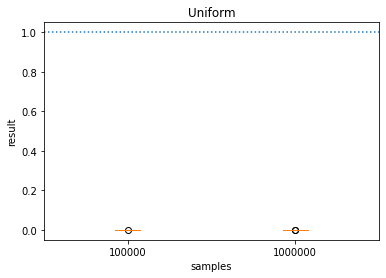

In [183]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('result')
plt.boxplot(g.values, labels=list(map(str,nitn_lst)));

In [184]:
temp_df.groupby('nitn')['result_means'].agg([np.mean, np.std])

,mean,std
nitn,,
100000,1.188427e-238,0.000000e+00
1000000,7.781990e-79,2.460881e-78


In [186]:
0 - target

-1

In [187]:
g = temp_df.groupby('nitn')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

nitn
100000     0.328821
1000000    3.515894
Name: result_times, dtype: float64

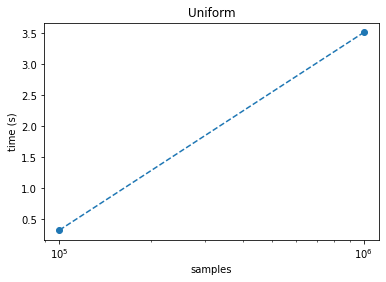

In [188]:
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

# locs, labels = plt.xticks()
# print(locs)
# plt.xticks(locs, ['', '1e5', '', '', '', '1e6', '', '', '', '1e7', '']);

# plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

##### batch

In [192]:
%%time
tf.random.set_seed(123)

ndims = 9
max_samples = 10**9

results = []
results_means = []
results_stddevs = []
result_times = []
result_runs = []

nitn_lst = list(map(int, [1e5, 1e6]))
run_lst = range(1,11)

for nitn in nitn_lst:
    for j, run in enumerate(run_lst):
        
        print(f'run={run} nitn={nitn}  b[{j*nitn}, {(j+1)*nitn}]')

        time_a = time.time()
        samples = tfp.mcmc.sample_halton_sequence(
            dim=ndims,
            sequence_indices=tf.range(start=j*nitn, limit=(j+1)*nitn, dtype=tf.int32),
            # num_results=nitn,
            dtype=tf.float64,
            randomized=True,
            seed=run
        ) * 2 - 1
        current_result = f2(samples) * 2 ** ndims
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)

        current_result_mean = tf.reduce_mean(current_result).numpy()
        current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result_mean)
        results_stddevs.append(current_result_stddev)
        results.append(current_result)

        print(current_result_mean, current_result_stddev)

run=1 nitn=100000  b[0, 100000]
0.0 0.0
run=2 nitn=100000  b[100000, 200000]
0.0 0.0
run=3 nitn=100000  b[200000, 300000]
0.0 0.0
run=4 nitn=100000  b[300000, 400000]
0.0 0.0
run=5 nitn=100000  b[400000, 500000]
0.0 0.0
run=6 nitn=100000  b[500000, 600000]
0.0 0.0
run=7 nitn=100000  b[600000, 700000]
0.0 0.0
run=8 nitn=100000  b[700000, 800000]
8.235048009153651e-227 0.0
run=9 nitn=100000  b[800000, 900000]
0.0 0.0
run=10 nitn=100000  b[900000, 1000000]
0.0 0.0
run=1 nitn=1000000  b[0, 1000000]
1.0594281111040677e-268 0.0
run=2 nitn=1000000  b[1000000, 2000000]
0.0 0.0
run=3 nitn=1000000  b[2000000, 3000000]
2.0179213129598427e-213 0.0
run=4 nitn=1000000  b[3000000, 4000000]
1.422094773162755e-271 0.0
run=5 nitn=1000000  b[4000000, 5000000]
2.303717451610283e-224 0.0
run=6 nitn=1000000  b[5000000, 6000000]
4.22720133593713e-145 4.2271992223359445e-142
run=7 nitn=1000000  b[6000000, 7000000]
1.0690979803027402e-203 0.0
run=8 nitn=1000000  b[7000000, 8000000]
1.2956861599519872e-285 0.0


In [193]:
# %%time
# tf.random.set_seed(123)

# ndims = 6
# max_samples = 10**9

# results = []
# results_means = []
# results_stddevs = []
# result_times = []
# result_runs = []

# epoch = 0
# current_precision = 1e99

# nitn_lst = list(map(int, [1e6]))
# run_lst = list(range(1,11))

# with tf.compat.v1.Session() as sess:

#     writer = tf.summary.create_file_writer(logdir)
#     tf.summary.trace_on(graph=True, profiler=True)

#     for run in run_lst:
#         for nitn in nitn_lst:

#             print(f'run={run} nitn={nitn}')
            
#             if run == run_lst[0] and nitn == nitn_lst[0]:
#                 print('building graph..')
#                 _ = sess.run(f1(tfp.mcmc.sample_halton_sequence(
#                     dim=ndims,
#                     #sequence_indices=sequence_indices,
#                     num_results=nitn,
#                     dtype=tf.float64,
#                     randomized=True,
#                     seed=123
#                 )) * 10 ** ndims)
#                 print('           - done')

#             time_a = time.time()
#             # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
#             # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
#             samples = tfp.mcmc.sample_halton_sequence(
#                 dim=ndims,
#                 #sequence_indices=sequence_indices,
#                 num_results=nitn,
#                 dtype=tf.float64,
#                 randomized=True,
#                 seed=run
#             )
#             # current_result = f1(samples) * 10 ** ndims
#             current_result = sess.run(f1(samples) * 10 ** ndims)
            
#             time_b = time.time() - time_a
#             result_times.append(time_b)
#             result_runs.append(run)

#             #current_result_mean = tf.reduce_mean(current_result).numpy()
#             #current_result_stddev = tf.math.reduce_std(current_result).numpy()
            
#             current_result_mean = np.mean(current_result)
#             current_result_stddev = np.std(current_result)

#             results_means.append(current_result_mean)
#             results_stddevs.append(current_result_stddev)
#             results.append(current_result)

#             print(current_result_mean, current_result_stddev)

In [194]:
temp_df = pd.DataFrame({'nitn': nitn_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs':results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.nitn

In [195]:
temp_df.groupby('nitn').apply(lambda x: variance_weighted_result(x['result_means'].values,
                                                                 x['results_stddevs'].values))

E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


nitn
100000     (nan, 0.0)
1000000    (nan, 0.0)
dtype: object

In [196]:
g = temp_df.groupby('nitn')['result_means'].apply(lambda x: x.tolist())

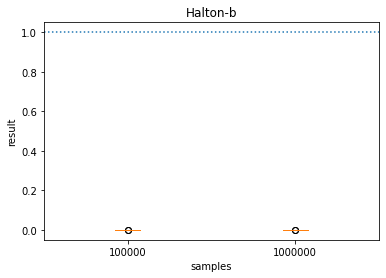

In [197]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('Halton-b')
plt.xlabel('samples')
plt.ylabel('result')
plt.boxplot(g.values, labels=list(map(str,nitn_lst)));

In [198]:
temp_df.groupby('nitn')['result_means'].agg([np.mean, np.std])

,mean,std
nitn,,
100000,1.069099e-204,0.000000e+00
1000000,4.227201e-146,1.336758e-145


In [202]:
0 - target

-1

In [200]:
g = temp_df.groupby('nitn')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

nitn
100000     2.114746
1000000    2.147857
Name: result_times, dtype: float64

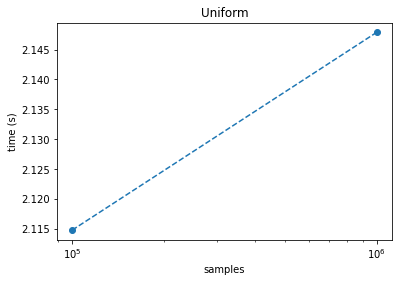

In [201]:
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

# locs, labels = plt.xticks()
# print(locs)
# plt.xticks(locs, ['', '1e5', '', '', '', '1e6', '', '', '', '1e7', '']);

# plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);

#### Sobol

##### simple

In [219]:
%%time
tf.random.set_seed(123)

ndims = 9
# max_samples = 10**9

results = []
results_means = []
results_stddevs = []
result_times = []
result_runs = []

nitn_lst = list(map(int, [1e6, 1e7, 1e8]))
run_lst = range(1,11)

for nitn in nitn_lst:
    for j, run in enumerate(run_lst):
        
        print(f'run={run} nitn={nitn}  b[{j*nitn}, {(j+1)*nitn}]')

        time_a = time.time()
        # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
        # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
        samples = tf.math.sobol_sample(
            dim=ndims,
            num_results=nitn,
            skip=j*nitn,
            dtype=tf.dtypes.float64,
            #name=None
        ) * 2 - 1
        current_result = f2(samples) * 2 ** ndims
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)

        current_result_mean = tf.reduce_mean(current_result).numpy()
        current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result_mean)
        results_stddevs.append(current_result_stddev)
        results.append(current_result)

        print(current_result_mean, current_result_stddev)

run=1 nitn=1000000  b[0, 1000000]
131057113106.48116 131057047577908.56
run=2 nitn=1000000  b[1000000, 2000000]
4.061882451069097e-103 4.061880420127349e-100
run=3 nitn=1000000  b[2000000, 3000000]
3.249145595214993e-278 0.0
run=4 nitn=1000000  b[3000000, 4000000]
1.3089069699673725e-267 0.0
run=5 nitn=1000000  b[4000000, 5000000]
9.997214777789986e-285 0.0
run=6 nitn=1000000  b[5000000, 6000000]
2.694087130421285e-250 0.0
run=7 nitn=1000000  b[6000000, 7000000]
3.953949221720235e-256 0.0
run=8 nitn=1000000  b[7000000, 8000000]
0.0 0.0
run=9 nitn=1000000  b[8000000, 9000000]
4.2955794152221955e-160 0.0
run=10 nitn=1000000  b[9000000, 10000000]
6.71592710414678e-269 0.0
run=1 nitn=10000000  b[0, 10000000]
13105711310.648115 41443896026083.08
run=2 nitn=10000000  b[10000000, 20000000]
5.102835412447911e-162 0.0
run=3 nitn=10000000  b[20000000, 30000000]
7.6632691094878e-190 0.0
run=4 nitn=10000000  b[30000000, 40000000]
9.682376847553397e-204 0.0
run=5 nitn=10000000  b[40000000, 50000000

In [229]:
# %%time
# tf.random.set_seed(123)

# ndims = 6
# max_samples = 10**9

# results = []
# results_means = []
# results_stddevs = []
# result_times = []
# result_runs = []

# epoch = 0
# current_precision = 1e99

# nitn_lst = list(map(int, [1e6]))
# run_lst = list(range(1,11))

# with tf.compat.v1.Session() as sess:

#     writer = tf.summary.create_file_writer(logdir)
#     tf.summary.trace_on(graph=True, profiler=True)

#     for run in run_lst:
#         for nitn in nitn_lst:

#             print(f'run={run} nitn={nitn}')
            
#             if run == run_lst[0] and nitn == nitn_lst[0]:
#                 print('building graph..')
#                 _ = sess.run(f1(tfp.mcmc.sample_halton_sequence(
#                     dim=ndims,
#                     #sequence_indices=sequence_indices,
#                     num_results=nitn,
#                     dtype=tf.float64,
#                     randomized=True,
#                     seed=123
#                 )) * 10 ** ndims)
#                 print('           - done')

#             time_a = time.time()
#             # sequence_indices = tf.range(start=0, limit=(epoch+1)*batch_size, dtype=tf.int32)
#             # sequence_indices = tf.range(start=0*batch_size, limit=(0+1)*batch_size, dtype=tf.int32)
#             samples = tfp.mcmc.sample_halton_sequence(
#                 dim=ndims,
#                 #sequence_indices=sequence_indices,
#                 num_results=nitn,
#                 dtype=tf.float64,
#                 randomized=True,
#                 seed=run
#             )
#             # current_result = f1(samples) * 10 ** ndims
#             current_result = sess.run(f1(samples) * 10 ** ndims)
            
#             time_b = time.time() - time_a
#             result_times.append(time_b)
#             result_runs.append(run)

#             #current_result_mean = tf.reduce_mean(current_result).numpy()
#             #current_result_stddev = tf.math.reduce_std(current_result).numpy()
            
#             current_result_mean = np.mean(current_result)
#             current_result_stddev = np.std(current_result)

#             results_means.append(current_result_mean)
#             results_stddevs.append(current_result_stddev)
#             results.append(current_result)

#             print(current_result_mean, current_result_stddev)

In [230]:
temp_df = pd.DataFrame({'nitn': nitn_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs':results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.nitn

In [231]:
temp_df.groupby('nitn').apply(lambda x: variance_weighted_result(x['result_means'].values,
                                                                 x['results_stddevs'].values))

E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == "__main__":
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


nitn
1000000      (nan, 0.0)
10000000     (nan, 0.0)
100000000    (nan, 0.0)
dtype: object

In [232]:
g = temp_df.groupby('nitn')['result_means'].apply(lambda x: x.tolist())

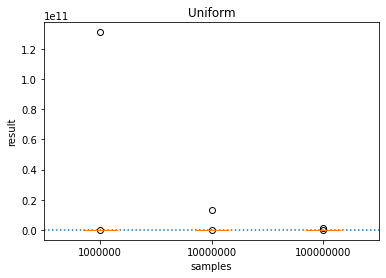

In [233]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('Uniform')
plt.xlabel('samples')
plt.ylabel('result')
plt.boxplot(g.values, labels=list(map(str,nitn_lst)));

In [234]:
temp_df.groupby('nitn')['result_means'].agg([np.mean, np.std])

,mean,std
nitn,,
1000000,1.310571e+10,4.144390e+10
10000000,1.310571e+09,4.144390e+09
100000000,1.310571e+08,4.144390e+08


In [237]:
1.310571e+08 - target

131057099.0

In [238]:
g = temp_df.groupby('nitn')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

nitn
1000000      28.333945
10000000     32.080129
100000000    32.379429
Name: result_times, dtype: float64

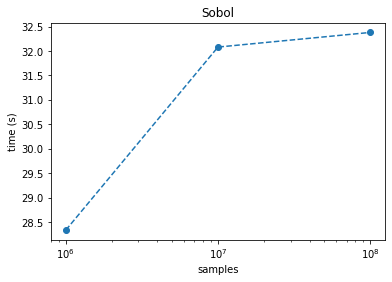

In [239]:
plt.title('Sobol')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

# locs, labels = plt.xticks()
# print(locs)
# plt.xticks(locs, ['', '1e5', '', '', '', '1e6', '', '', '', '1e7', '']);

# plt.boxplot(g.values, labels=['1e5', '1e6', '1e7']);